In [1]:
# for folders one level below the heirarchy
import sys
import os 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

from aodfunctions.dependencies import *
from aodfunctions.general import *
from aodfunctions.settings import *
from aodfunctions.testbed import *

cupyon=True

try:
    import cupy as cp
    import numpy as np
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
    from cupy.lib.stride_tricks import as_strided

except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    print("cupy not installed. Using numpy.")


Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  14.999999999999998
Fourier space spacing in microns:  0.09331054687500001
Fourier space aperture in microns:  382.20000000000005
Timestep in nanoseconds: 23.076923076923077


In [2]:
## Global Variables - REMEMBER TO UPDATE SETTINGS WHEN CHANGED
# Hardware-defined Constants. Note that all explicit variable values are in position (m), frequency (1/m), or time (s). Conversions are done explicitly to relevant time/distance scales.
aodaperture = 7.5e-3 # Aperture size of the AOD
soundvelocity = 650   # Sound velocity in the medium
cycletime = aodaperture / soundvelocity  # Time for one cycle of the waveform
focallength = 9.1 * 10**(-3) # mm
wavelength = 630 * 10**(-9)

print("Cycletime in nanoseconds: ", cycletime * 1e9)

# Simulation Constants
numpix_frame = 500
numpix_real = 4096
pixelsize_real = aodaperture / numpix_frame
aperturesize_real = numpix_real * pixelsize_real
aperturesize_fourier = wavelength * focallength / (pixelsize_real)
pixelsize_fourier = aperturesize_fourier / numpix_real
print("Aod pixel pitch in microns: ", pixelsize_real*1e6)
print("Fourier space spacing in microns: ", pixelsize_fourier*10**6)
print("Fourier space aperture in microns: ", aperturesize_fourier*10**6)

# Adjustable Variables
movementtime = 100*10**(-6) # Time for the movement of the AOD
timestep = cycletime / numpix_frame
print("Timestep in nanoseconds:", timestep * 10**9)
startlocation = -10*10**(-6) # Start location of the AOD in microns. 0 is set to the center of Fourier space.
endlocation = 10*10**(-6) # End location of the AOD in microns


optimizationbasisfunctions = 'Chebyshev'  # Basis for the polynomial fit
numcoefficients = 100

num_particles = 10000
atommass = 1.41922*10**(-25) # Mass of the atom
tweezerdepth = 10*10**6 # Depth of the tweezer in Hertz
hbar = 6.626*10**(-34)


globalvariables = [aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients]
aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables



Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  14.999999999999998
Fourier space spacing in microns:  0.09331054687500001
Fourier space aperture in microns:  382.20000000000005
Timestep in nanoseconds: 23.076923076923077


In [3]:
### From the global variables, initialize the AWG waveform
numpix_waveform = int(movementtime / cycletime * numpix_frame) + 2* numpix_frame # Why is there a 2* cycletime here? To add on the initial and final stages of the AOD. We will only change the portion in the movement time and fix the ends.
AWGwaveform = cp.zeros(numpix_waveform)

print("Tweezer starting positions:", startlocation*10**6, "microns or", micronstoMHz(startlocation, globalvariables) /10**6, "MHz")
print("Tweezer ending positions:", endlocation*10**6, "microns or", micronstoMHz(endlocation, globalvariables) /10**6, "MHz")
print("One micron corresponds to", micronstoMHz(1e-6, globalvariables) /10**6, "MHz")

Tweezer starting positions: -10.0 microns or -1.133786848072562 MHz
Tweezer ending positions: 10.0 microns or 1.133786848072562 MHz
One micron corresponds to 0.1133786848072586 MHz


In [4]:
# optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time = initpath_linearramp(globalvariables)
# optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time = initpath_minimizejerk(globalvariables)


optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time  = initpath_sinsqramp(globalvariables)

fourierpixels, time = positionstofourier(optimized_position, time, globalvariables)
expanded_position, expanded_time = expand_position_array(time, fourierpixels, globalvariables)

AWGinitguess = initguess_waveform(AWGwaveform, optimized_position, time, globalvariables)
AWGinitguesscosine = cosinephaseresponse(AWGinitguess)
AWGinitguessexponential = exponentialphaseresponse(AWGinitguess)
potentials = retrievepotentials(AWGinitguessexponential, globalvariables, 1, True)
forces = retrieveforces(AWGinitguessexponential, globalvariables, 1, True)
initial_x_dx= initdistribution_MaxwellBoltzmann(num_particles, 40e-6, 1e-8, atommass, globalvariables)



# Mid-code visualizations
# plot_arrays([(tonumpy(zoomin(potentials[0] /hbar/10**6, 2))), zoomin(forces[0] /hbar/10**6 /10**6,50000).get(),zoomin(forces[0] /atommass,50000).get()], ["Potential (MHz)", "Force (MHz / micron)", "Acceleration (m/s^2)"])

# plt.figure(figsize=(12, 6))
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[0:500],globalvariables)).get())
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[-500:],globalvariables)).get())
# plt.plot(potentials[-1].get())
# plt.plot(potentials[0].get())


# plt.axvline(x=positionstofourier(startlocation, 0, globalvariables)[0], color='red', linestyle='--')
# plt.axvline(x=positionstofourier(endlocation, 0, globalvariables)[0], color='blue', linestyle='--')
# print(positionstofourier(startlocation, 0, globalvariables)[0])
# print(positionstofourier(endlocation, 0, globalvariables)[0])


# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# ax1.hist(initial_x_dx[0], color='blue')
# ax1.set_title('Position')
# ax1.set_xlabel('Fourier Pixels')
# ax1.set_ylabel('Count')

# ax2.hist(initial_x_dx[1], color='red')
# ax2.set_title('Velocity')
# ax2.set_xlabel('m/s')
# ax2.set_ylabel('Count')

# plt.tight_layout()
# plt.show()

In [5]:
forces = retrieveforces_idealconditions(AWGinitguessexponential, optimized_position,globalvariables)
forces_notideal = retrieveforces(AWGinitguessexponential, globalvariables, 1, False)
potentials = retrievepotentials(AWGinitguessexponential, globalvariables, 1, False)
potentials_ideal = retrievepotentials_idealconditions(AWGinitguessexponential, optimized_position, globalvariables)
rescalingfac = np.max(np.gradient(potentials_ideal[0])) / np.max(gradient(potentials[0]).get())
rescalingfac2 = np.max((potentials_ideal[0])) / np.max((potentials[0]).get())

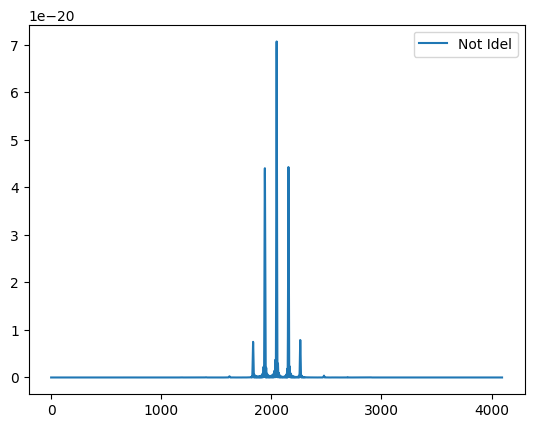

In [8]:
plt.plot(tonumpy(potentials[0]*rescalingfac2), label='Not Idel')
# plt.plot(tonumpy(potentials[1800]*rescalingfac2), label='Not Idea')
# plt.plot((potentials_ideal[0]), label='Not Ida')
# plt.plot((potentials_ideal[900]), label='Not Id')
# plt.plot((potentials_ideal[1600]), label='Not Id')
# plt.plot((potentials_ideal[1700]), label='Not Id')

plt.legend()

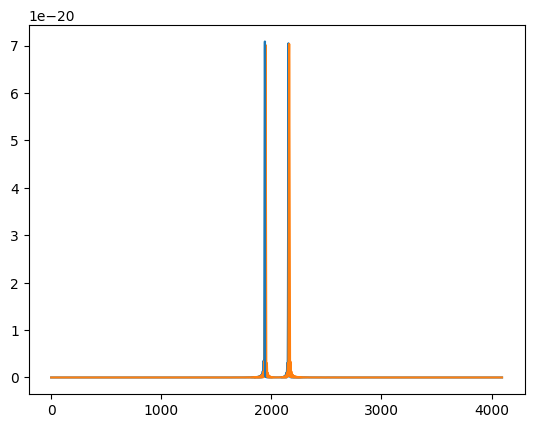

In [ ]:
plt.plot(tonumpy(potentials_ideal[0]), label='Not Idel')
plt.plot(tonumpy(potentials_ideal[200]), label='Not Idel')

plt.plot(tonumpy(potentials_ideal[450]), label='Not Idel')

plt.plot(tonumpy(potentials_ideal[600]), label='Not Idel')

plt.vlines(x =find_max_peak_location((tonumpy(potentials_ideal[0]))), ymin = 0, ymax = np.max(tonumpy(potentials[0]*rescalingfac2)))


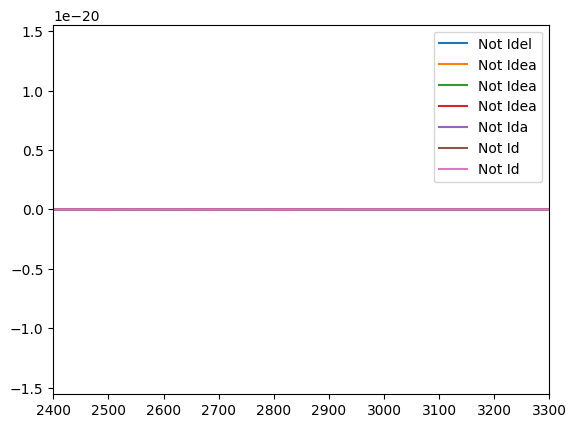

In [ ]:
plt.plot(gradient(potentials[500]).get()*rescalingfac, label='Not Idel')
plt.plot(gradient(potentials[1800]).get()*rescalingfac, label='Not Idea')
plt.plot(gradient(potentials[0]).get()*rescalingfac, label='Not Idea')
plt.plot(gradient(potentials[900]).get()*rescalingfac, label='Not Idea')

plt.plot(np.gradient(potentials_ideal[500]), label='Not Ida')
plt.plot(np.gradient(potentials_ideal[1800]), label='Not Id')
plt.plot(np.gradient(potentials_ideal[0]), label='Not Id')

plt.xlim(2400,3300)

plt.legend()

In [ ]:
# plot_arrays([(tonumpy(zoomin(potentials[0] /hbar/10**6, 2))), zoomin(forces[0] /hbar/10**6 /10**6,50000).get(),zoomin(forces[0] /atommass,50000).get()], ["Potential (MHz)", "Force (MHz / micron)", "Acceleration (m/s^2)"])

# plt.figure(figsize=(12, 6))
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[0:500],globalvariables)).get())
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[3000:3500],globalvariables)).get())
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[-500:],globalvariables)).get())
# plt.plot(potentials[-1].get())
# plt.plot(potentials[0].get())
# plt.xlim(2400,2900)

# plt.axvline(x=positionstofourier(startlocation, 0, globalvariables)[0], color='red', linestyle='--')
# plt.axvline(x=positionstofourier(endlocation, 0, globalvariables)[0], color='blue', linestyle='--')
# print(positionstofourier(startlocation, 0, globalvariables)[0])
# print(positionstofourier(endlocation, 0, globalvariables)[0])


# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# ax1.hist(initial_x_dx[0], color='blue')
# ax1.set_title('Position')
# ax1.set_xlabel('Fourier Pixels')
# ax1.set_ylabel('Count')

# ax2.hist(initial_x_dx[1], color='red')
# ax2.set_title('Velocity')
# ax2.set_xlabel('m/s')
# ax2.set_ylabel('Count')

# plt.tight_layout()
# plt.show()

In [ ]:
from aodfunctions.general import *

In [4]:
movetimes = np.arange(100,150,10)*10**(-6)
movetemperatures = np.array([1])*10**(-6)

# movetimes = np.array([200])*10**(-6)
# movetemperatures = np.array([1])*10**(-6)


# ideallinear = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Ideal", "Linear", 1, globalvariables)
# notideallinear = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Not Ideal", "Linear", 1, globalvariables)
# idealsinsq = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Ideal", "SinSq", 1, globalvariables)
notidealsinsq = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Not Ideal", "SinSq", 1, globalvariables)


2.1888359270963612e-20
2.4418430690343986e-20
1.1054586346783352e-20
1.0373447779778233e-20
2.602493032717938e-20


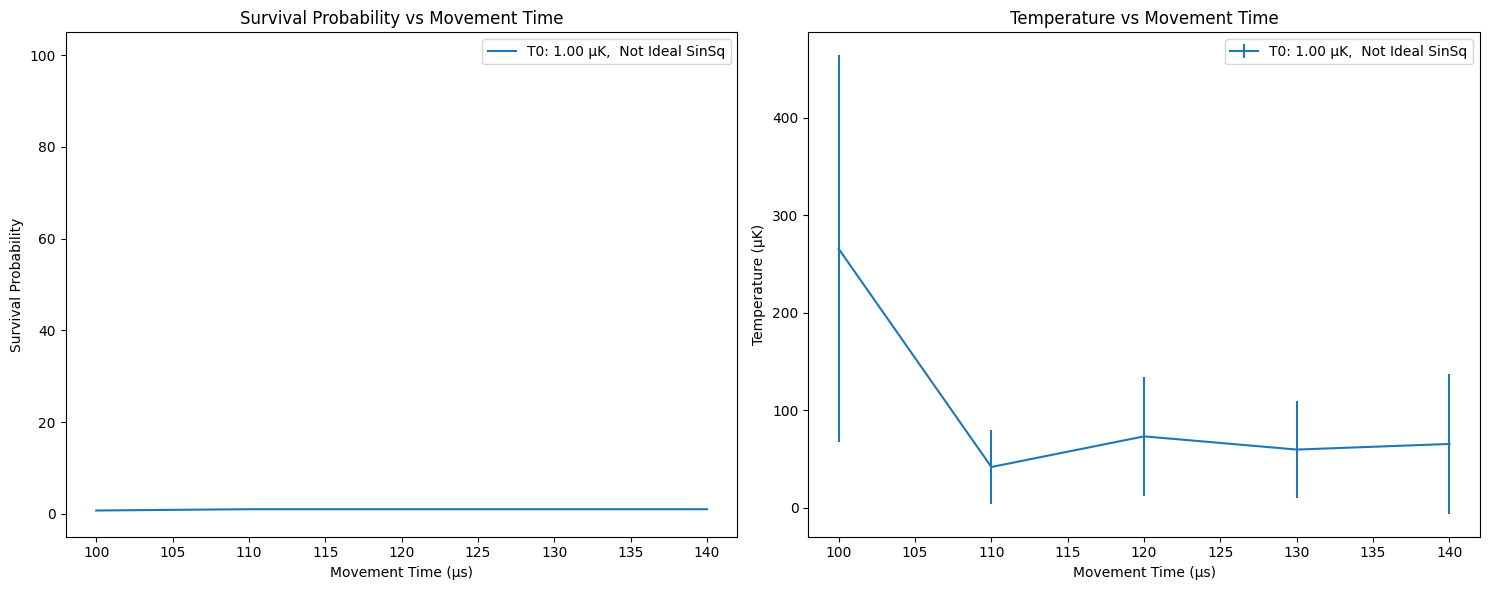

In [5]:
plots_fixeddistance_multipleanalysis(movetimes, movetemperatures, np.array([notidealsinsq]), np.array(["Not Ideal SinSq"]))

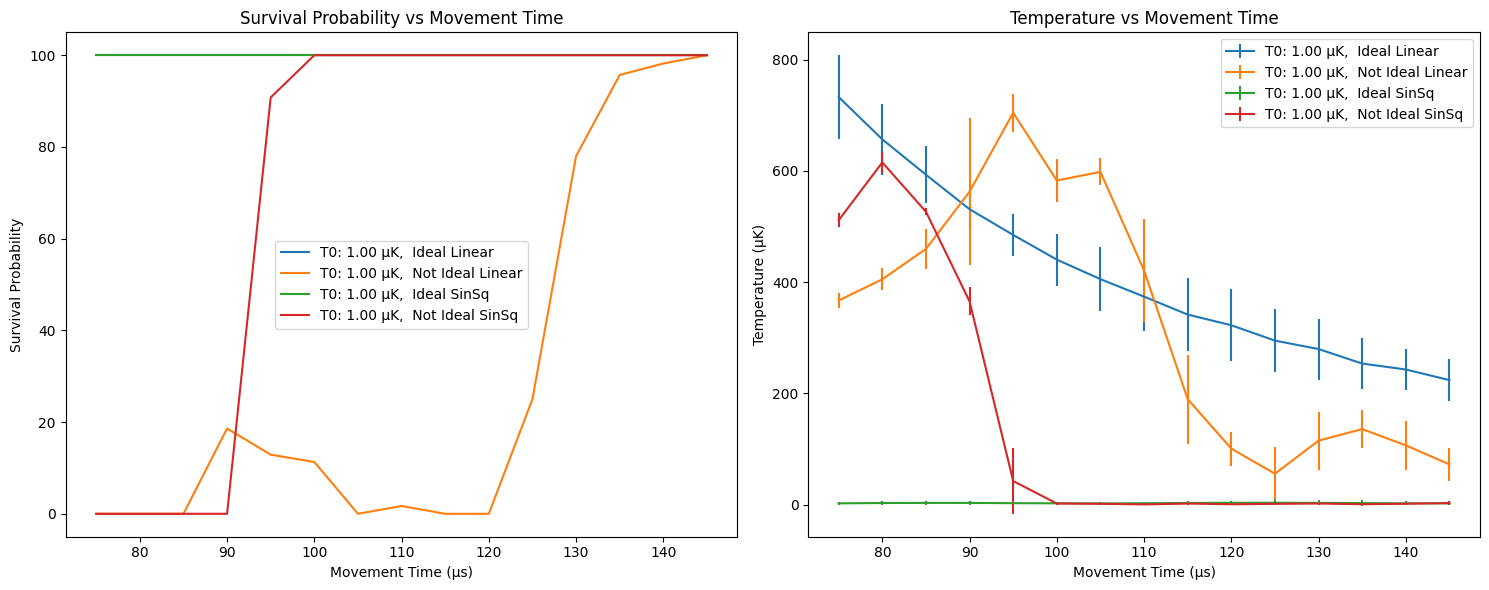

In [55]:
plots_fixeddistance_multipleanalysis(movetimes, movetemperatures, np.array([ideallinear, notideallinear, idealsinsq, notidealsinsq]), np.array(["Ideal Linear", "Not Ideal Linear", "Ideal SinSq", "Not Ideal SinSq"]))

In [34]:
from numpy.polynomial.legendre import legval
from scipy.optimize import dual_annealing
from scipy.optimize import differential_evolution, minimize
from numpy.polynomial.legendre import Legendre


def constructamplitudes(amplitudes, optimizationspace):
    ### Chose a Legendre basis for the optimization space
    amplitudes = tonumpy(amplitudes)
    optimizationspace = tonumpy(optimizationspace)
    
    constructed_values = legval(optimizationspace, amplitudes)
    
    return tocupy(constructed_values)

def constructphases(phases, optimizationspace):
    ### Chose a Legendre basis for the optimization space
    phases = tonumpy(phases)
    optimizationspace = tonumpy(optimizationspace)
    
    constructed_values = legval(optimizationspace, phases)
    
    return tocupy(constructed_values)

def constructFourierVariant(optimizationspace, frequencies, amplitudes, phases, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    constructedwaveform = cp.zeros(len(optimizationspace))
    for i in range(len(frequencies)):
        amplitudeprofile = constructamplitudes(amplitudes[i], optimizationspace)
        phaseprofile = constructphases(phases[i], optimizationspace)
        frequencyprofile = cp.linspace(frequencies[i], frequencies[i]*len(optimizationspace), len(optimizationspace))
        constructedwaveform += amplitudeprofile * np.cos(2*np.pi*frequencyprofile*optimizationspace + phaseprofile)
    
    return tocupy(constructedwaveform)

def init_opt_waveformfitFourierVariant(AWGinitguess,freqres, ampres, phaseres, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    
    AWGwaveform = cp.zeros(len(AWGinitguess))
    AWGwaveform[0:numpix_frame] = AWGinitguess[0:numpix_frame]
    AWGwaveform[-numpix_frame:] = AWGinitguess[-numpix_frame:]
    
    optimizationsection = AWGinitguess[numpix_frame:-numpix_frame]
    optimizationspace = cp.linspace(0,len(AWGinitguess) / numpix_real,len(AWGinitguess))[numpix_frame:-numpix_frame]
    
    startfrequency = positionstofourier(startlocation, 0, globalvariables)[0] - numpix_real // 2
    endfrequency = positionstofourier(endlocation, 0, globalvariables)[0] - numpix_real // 2
    
    frequencies = cp.linspace(startfrequency, endfrequency, freqres) # in units of pixels
    amplitudes = cp.random.rand(freqres, ampres) # arbitrary units
    phases = cp.zeros((freqres, phaseres)) # in units of pixels
    
    
    constructedwaveform = constructFourierVariant(optimizationspace, frequencies, amplitudes, phases, globalvariables )
    
    
    def objective(params):
        num_frequencies = len(frequencies)
        num_amplitudes = ampres
        num_phases = phaseres
        
        amplitudes = tocupy(params[:num_frequencies * num_amplitudes].reshape((num_frequencies, num_amplitudes)))
        phases = tocupy(params[num_frequencies * num_amplitudes:].reshape((num_frequencies, num_phases)))
        
        reconstructed_waveform = constructFourierVariant(optimizationspace, frequencies, amplitudes, phases, globalvariables)
        error = cp.sum((reconstructed_waveform - optimizationsection)**2)
        print(error)
        return tonumpy(error)
    
    initial_guess = cp.concatenate([amplitudes.flatten(), phases.flatten()])
    # result = minimize(objective, tonumpy(initial_guess), method='L-BFGS-B')
    # First step: Differential Evolution    
    # Second step: Local Gradient Descent
    result_gd = minimize(objective, initial_guess.get(), method='L-BFGS-B')

    optimized_params = result_gd.x
    opt_amplitudes = optimized_params[:freqres * ampres].reshape((freqres, ampres))
    opt_phases = optimized_params[freqres * ampres:].reshape((freqres, phaseres))
    
    optimizedwaveform = constructFourierVariant(optimizationspace, frequencies, opt_amplitudes, opt_phases, globalvariables)
    
    AWGwaveform[numpix_frame:-numpix_frame] = optimizedwaveform
    parameters = [frequencies, opt_amplitudes, opt_phases]
    return AWGwaveform, parameters



# Do a Legendre fit to the data

def fit_legendre_polynomial(x, y, degree):
    """
    Fits a Legendre polynomial to the given data.
    
    Parameters:
    x (array-like): The x-coordinates of the data points.
    y (array-like): The y-coordinates of the data points.
    degree (int): The degree of the Legendre polynomial.
    
    Returns:
    Legendre: The fitted Legendre polynomial.
    """
    # Fit the Legendre polynomial
    coeffs = Legendre.fit(x, y, degree).convert().coef
    
    # Create a Legendre object with the coefficients
    legendre_poly = Legendre(coeffs)
    
    return legendre_poly

def init_opt_waveformfitLegendre(AWGinitguess,degree, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    
    AWGwaveform = cp.zeros(len(AWGinitguess))
    AWGwaveform[0:numpix_frame] = AWGinitguess[0:numpix_frame]
    AWGwaveform[-numpix_frame:] = AWGinitguess[-numpix_frame:]
    
    optimizationsection = AWGinitguess[numpix_frame:-numpix_frame]
    optimizationspace = cp.linspace(-1,1,len(optimizationsection))
    
    startfrequency = positionstofourier(startlocation, 0, globalvariables)[0] - numpix_real // 2
    endfrequency = positionstofourier(endlocation, 0, globalvariables)[0] - numpix_real // 2

    
    fitted_legendre = fit_legendre_polynomial(tonumpy(optimizationspace), tonumpy(optimizationsection), degree)
    fitted_section = fitted_legendre(optimizationspace)
    max_error = np.max(np.abs(optimizationsection - fitted_section))
    print("Maximum error:", max_error)
    
    AWGwaveform[numpix_frame:-numpix_frame] = fitted_section
    return tocupy(AWGwaveform), tocupy(fitted_legendre.coef)

def opt_atomsurvival_Legendre(fittedwaveform, fittedcoefficients, inittemperature, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    
    AWGwaveform = cp.zeros(len(fittedwaveform))
    AWGwave_template = tonumpy(fittedwaveform.copy())
    AWGwaveform_expresponse = exponentialphaseresponse(fittedwaveform)
    optimizationsection = fittedwaveform[numpix_frame:-numpix_frame]
    optimizationspace = cp.linspace(-1,1,len(optimizationsection))
    
    initial_distributions = initdistribution_MaxwellBoltzmann(num_particles, inittemperature, 1e-8, atommass, globalvariables)
    shotlast = realtofourier(zeropadframe(AWGwaveform_expresponse[-numpix_frame:], globalvariables))
    gaussianwidth = get_gaussianwidth_1d(tonumpy(zoomin((shotlast), 2)))
    plt.plot(tonumpy((shotlast)))
    plt.show()
    print(gaussianwidth)
    endtweezerlocation = get_gaussiancenter_1d((shotlast))
    print(endtweezerlocation)
    print(len(initial_distributions[0]))
    
    def objective_survivalLegendre(params):
        legendre_poly = Legendre(params)
        reconstructed_waveform = legendre_poly(tonumpy(optimizationspace))
        AWGwave_template[numpix_frame:-numpix_frame] = reconstructed_waveform
        AWGwave_test = exponentialphaseresponse(tocupy(AWGwave_template))
        print("waveform made")
        forces = retrieveforces(AWGwave_test, globalvariables, 10, True)
        print("forces made")
        xout, vout, accel = montecarlo(forces, globalvariables, initial_distributions, atommass)
        print("xout retrieved", len(xout))
        survivalprobability = analyze_survivalprobability(xout, endtweezerlocation, gaussianwidth, globalvariables)
        print("survivalprobability retrieved")

        print(survivalprobability)
        return 1 - survivalprobability

    initial_guess = fittedcoefficients
    result_gd = minimize(objective_survivalLegendre, tonumpy(initial_guess), method='L-BFGS-B')

    optimized_coefficients= result_gd.x

    fitted_legendrepoly = Legendre(optimized_coefficients)
    AWGwaveform[numpix_frame:-numpix_frame] = tocupy(fitted_legendrepoly(tonumpy(optimizationspace)))
    
    return AWGwaveform, optimized_coefficients


def constructPhaseOnlyVariant(optimizationspace, frequencies, phases, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    constructedwaveform = cp.zeros(len(optimizationspace))
    for i in range(len(frequencies)):
        phaseprofile = constructphases(phases[i], optimizationspace)
        frequencyprofile = cp.linspace(frequencies[i], frequencies[i]*len(optimizationspace), len(optimizationspace))
        constructedwaveform += np.cos(2*np.pi*frequencyprofile*optimizationspace + phaseprofile)
    
    return tocupy(constructedwaveform)

def opt_waveform_phaseonly(AWGinitguess, positions, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables

    AWGwaveform = cp.zeros(len(AWGinitguess))
    AWGwaveform[0:numpix_frame] = AWGinitguess[0:numpix_frame]
    AWGwaveform[-numpix_frame:] = AWGinitguess[-numpix_frame:]
    
    optimizationsection = AWGinitguess[numpix_frame:-numpix_frame]
    optimizationspace = cp.linspace(-1,1,len(AWGinitguess))[numpix_frame:-numpix_frame]
    
    
    AWG_fourierspace = cp.zeros(len(AWGwaveform))
    fourierpixels, time = positionstofourier(positions, 0, globalvariables)
    expanded_fourierpixels, expanded_time = expand_position_array(time, fourierpixels, globalvariables)
    AWG_fourierspace[numpix_frame: -numpix_frame] = tocupy(expanded_fourierpixels)
    frequency_t0 = fourierpixels[0]
    frequency_tF = fourierpixels[-1]
    AWG_fourierspace[0:numpix_frame] = frequency_t0
    AWG_fourierspace[-numpix_frame:] = frequency_tF
    AWG_time = cp.linspace(0, 1*len(AWGwaveform) / numpix_real, len(AWGwaveform))
    
    AWG_fourierspace = AWG_fourierspace - numpix_real // 2

    AWGwaveform_out = cp.cos(2*cp.pi*cp.cumsum(AWG_fourierspace) * (AWG_time[1] - AWG_time[0]))
    
    

    return

def analyze_survivalprobability(xout, finalposition, gaussianwidth, globalvariables):
    """
    Calculate the percentage of values in xout that are within 1 Gaussian width of the final position.
    
    Parameters:
    xout (cp.ndarray): Array of values to analyze.
    gaussianwidth (float): The width of the Gaussian.
    globalvariables (dict): A dictionary of global variables.
    
    Returns:
    float: The percentage of values within 1 Gaussian width of the final position.
    """
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    # finalposition, _ = positionstofourier(endlocation, 0, globalvariables)
    
    xout = tonumpy(xout)
    
    # Calculate the lower and upper bounds
    lower_bound = finalposition - gaussianwidth
    upper_bound = finalposition + gaussianwidth
    # Count the number of values within the bounds
    count_within_bounds = np.sum((xout >= lower_bound) & (xout <= upper_bound))
    # Calculate the percentage
    percentage_within_bounds = count_within_bounds / len(xout) 
    
    return percentage_within_bounds

In [35]:
optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time  = initpath_sinsqramp(globalvariables)

fourierpixels, time = positionstofourier(optimized_position, time, globalvariables)
expanded_position, expanded_time = expand_position_array(time, fourierpixels, globalvariables)

AWGinitguess = initguess_waveform(AWGwaveform, optimized_position, time, globalvariables)
fittedwaveform, fittedlegendre = init_opt_waveformfitLegendre(AWGinitguess, 1000, globalvariables)

c:\Users\CavityQED\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\polynomial\legendre.py:1412: RankWarning: The fit may be poorly conditioned
  return pu._fit(legvander, x, y, deg, rcond, full, w)


Maximum error: 1.6778163135222623e-07


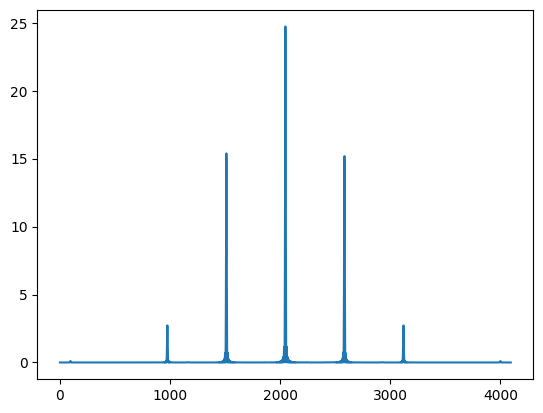

In [37]:
plt.plot(tonumpy(realtofourier(zeropadframe(exponentialphaseresponse(AWGinitguess)[-numpix_frame:], globalvariables))))


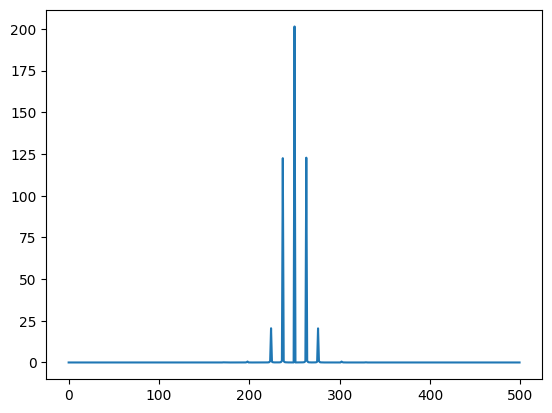

In [45]:
plt.plot(realtofourier(exponentialphaseresponse(AWGinitguess)[0:500]).get())

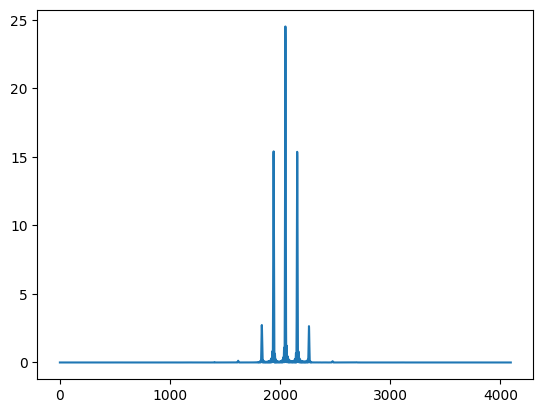

191.01090384710682
2048.9878126943213
10000
waveform made
forces made


KeyboardInterrupt: 

In [22]:
optimizedwaveform, optimizedLegendre = opt_atomsurvival_Legendre(fittedwaveform, fittedlegendre, 1e-6, globalvariables)

In [9]:
positionstofourier(endlocation, 0, globalvariables)

(2155.1690214547357, 0)

In [19]:
fittedAWGguesscosine = init_opt_waveformfitFourierVariant(AWGinitguesscosine, 500, 40, 40, globalvariables)

147559.92037742093
147559.92037829227
147559.92037769867
147559.92037711706
147559.92037707777
147559.92037746354
147559.9203777142
147559.92037754093
147559.9203772421
147559.92037723528
147559.9203774794
147559.9203775918
147559.92037744066
147559.92037730268
147559.92037738266
147559.92037749954
147559.92037743726
147559.9203773345
147559.92037742157
147559.92037756206


KeyboardInterrupt: 

-107.16902145473568


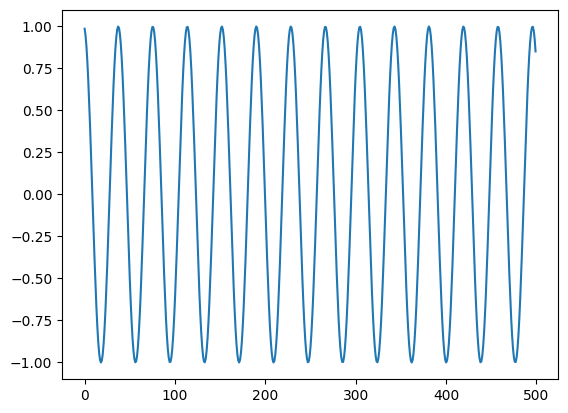

In [20]:
times = np.linspace(0,len(AWGinitguesscosine) / numpix_real,len(AWGinitguesscosine))
frequency1 = positionstofourier(-10e-6, 0, globalvariables)[0] - numpix_real // 2
print(frequency1)
frequencies = np.ones(len(AWGinitguesscosine)) * frequency1
test = np.cos(2*np.pi*np.cumsum(frequencies) *(times[1] - times[0]))

plt.plot(test[0:500])

In [88]:
np.cumsum(frequencies)

array([-1.07169021e+02, -2.14338043e+02, -3.21507064e+02, ...,
       -2.46274411e+05, -2.46381580e+05, -2.46488749e+05])

In [89]:
np.linspace(frequency1, frequency1*len(AWGinitguesscosine), len(AWGinitguesscosine))

array([-1.07169021e+02, -2.14338043e+02, -3.21507064e+02, ...,
       -2.46274411e+05, -2.46381580e+05, -2.46488749e+05])

In [76]:
len(AWGinitguesscosine)

2300

-107.16902145473568


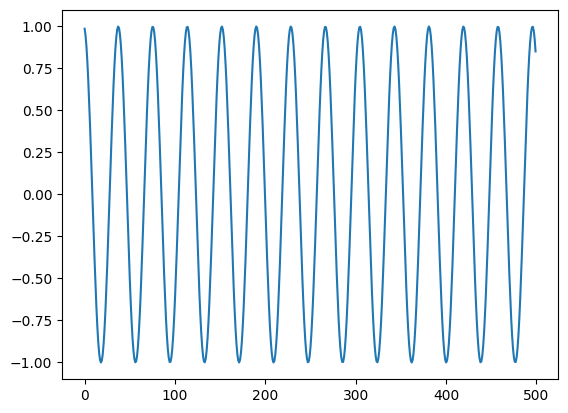

In [86]:
times = np.linspace(0,len(AWGinitguesscosine) / numpix_real,len(AWGinitguesscosine))
frequency1 = positionstofourier(-10e-6, 0, globalvariables)[0] - numpix_real // 2
print(frequency1)
frequencies = np.ones(len(AWGinitguesscosine)) * frequency1
test = np.cos(2*np.pi*np.cumsum(frequencies) *(times[1] - times[0]))

plt.plot(test[0:500])

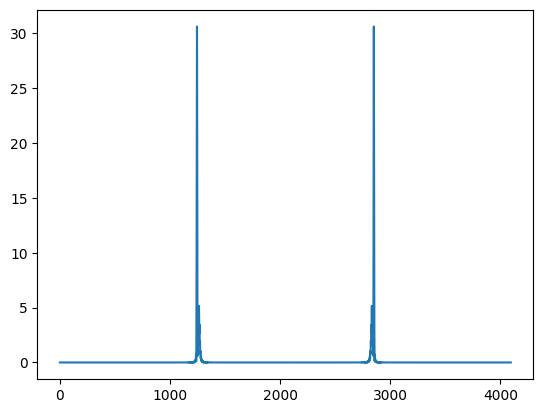

In [ ]:
plt.plot(potentials[-400].get())




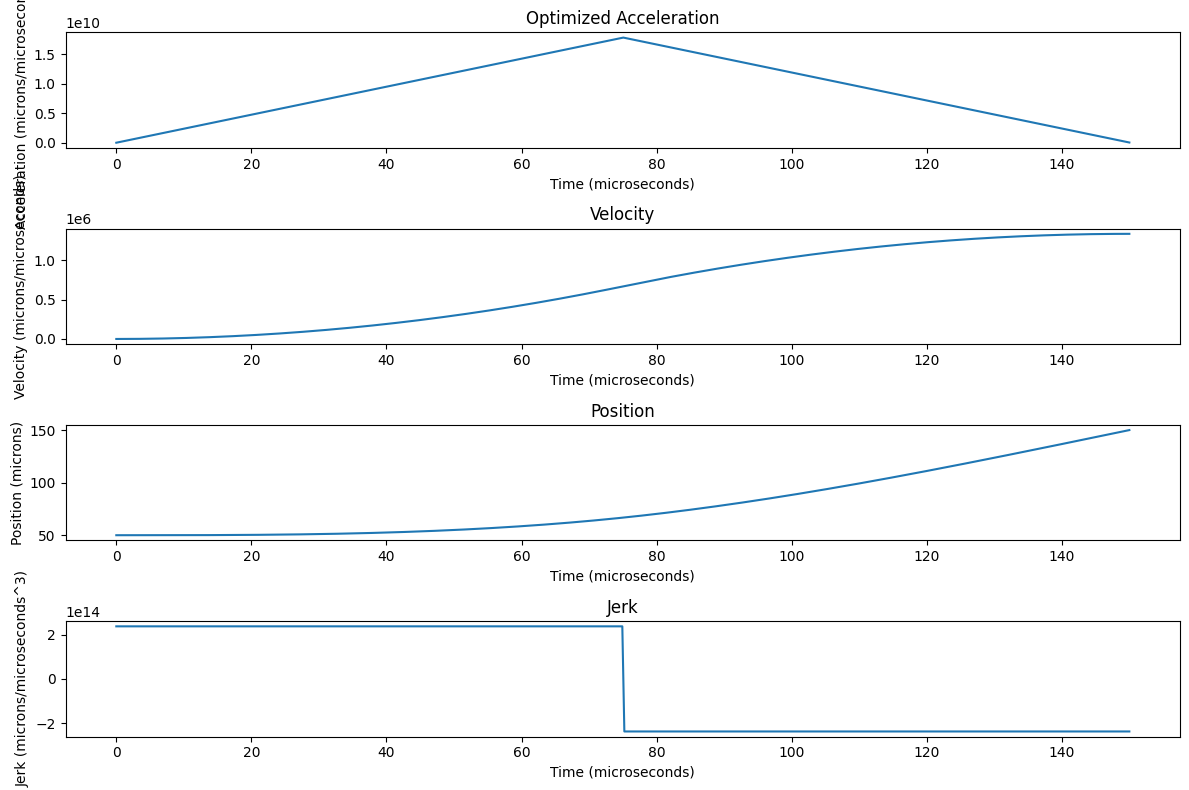

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(time * 10**6, optimized_acceleration * 10**6)
plt.title('Optimized Acceleration')
plt.xlabel('Time (microseconds)')
plt.ylabel('Acceleration (microns/microseconds^2)')

plt.subplot(4, 1, 2)
plt.plot(time* 10**6, optimized_velocity* 10**6)
plt.title('Velocity')
plt.xlabel('Time (microseconds)')
plt.ylabel('Velocity (microns/microseconds)')

plt.subplot(4, 1, 3)
plt.plot(time* 10**6, optimized_position* 10**6)
plt.title('Position')
plt.xlabel('Time (microseconds)')
plt.ylabel('Position (microns)')

plt.subplot(4, 1, 4)
plt.plot(time* 10**6, optimized_jerk* 10**6)
plt.title('Jerk')
plt.xlabel('Time (microseconds)')
plt.ylabel('Jerk (microns/microseconds^3)')

plt.tight_layout()
plt.show()